In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import json

In [ ]:
# import dask.dataframe as dd

# file_path = "/content/drive/MyDrive/yelp_dataset/yelp_academic_dataset_review.json"

# # Load JSON as a Dask DataFrame
# df = dd.read_json(file_path, lines=True, blocksize="100MB")  # Adjust blocksize as needed
# print(df.head())


In [ ]:
file_path = "/content/drive/MyDrive/yelp_dataset/yelp_academic_dataset_review.json"
output_csv = "/content/drive/MyDrive/yelp_dataset/review_sample.csv"

# Process & Save the first 100,000 rows into CSV
chunk_size = 500000
data = []

with open(file_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= chunk_size:
            break
        data.append(json.loads(line))

df = pd.DataFrame(data)
df.to_csv(output_csv, index=False)

print("Saved subset to CSV! Now you can read it quickly in Pandas.")


Saved subset to CSV! Now you can read it quickly in Pandas.


In [ ]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
def preprocess_text(text):
    if pd.isna(text):  # Handle missing values
        return ""
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatization
    return ' '.join(tokens)

# Use `meta=('cleaned_text', 'object')` to explicitly define the output type
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Display results
print(df[['text', 'cleaned_text']].head())

                                                text  \
0  If you decide to eat here, just be aware it is...   
1  I've taken a lot of spin classes over the year...   
2  Family diner. Had the buffet. Eclectic assortm...   
3  Wow!  Yummy, different,  delicious.   Our favo...   
4  Cute interior and owner (?) gave us tour of up...   

                                        cleaned_text  
0  decide eat aware going take 2 hour beginning e...  
1  taken lot spin class year nothing compare clas...  
2  family diner buffet eclectic assortment large ...  
3  wow yummy different delicious favorite lamb cu...  
4  cute interior owner gave u tour upcoming patio...  


In [ ]:
# Save the cleaned DataFrame to a CSV
df[['text', 'cleaned_text', 'stars']].to_csv("/content/drive/MyDrive/yelp_dataset/cleaned_reviews.csv", index=False)
print("✅ Cleaned text saved to CSV.")


✅ Cleaned text saved to CSV.


# Bert Embeddings

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained BERT model and tokenizer, move model to GPU
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Custom Dataset for Batch Processing
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# Function to get BERT embeddings in batches with FP16 for faster computation
def get_bert_embeddings(texts, batch_size=64):
    dataset = TextDataset(texts)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_embeddings = []
    model.eval()

    total_batches = len(dataloader)
    print(f"Total Batches: {total_batches}")

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=256)
            inputs = {key: value.to(device) for key, value in inputs.items()}

            # Mixed precision for faster processing
            with autocast():
                outputs = model(**inputs)

            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embeddings.extend(batch_embeddings)

            # Print progress every 100 batches
            if (i + 1) % 100 == 0:
                print(f"Processed {i+1}/{total_batches} batches...")

    return all_embeddings

# Apply optimized batch processing
df['bert_embedding'] = get_bert_embeddings(df['cleaned_text'].tolist(), batch_size=64)

# Convert to numerical format and move to CUDA
X_embeddings = torch.tensor(df['bert_embedding'].tolist(), device=device)

print(f"BERT Embedding Shape: {X_embeddings.shape}")
print("BERT Embeddings Successfully Extracted on CUDA (Batch Optimized with FP16)")


Using device: cuda
Total Batches: 7813


<ipython-input-16-100d6ebd2577>:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Processed 100/7813 batches...
Processed 200/7813 batches...
Processed 300/7813 batches...
Processed 400/7813 batches...
Processed 500/7813 batches...
Processed 600/7813 batches...
Processed 700/7813 batches...
Processed 800/7813 batches...
Processed 900/7813 batches...
Processed 1000/7813 batches...
Processed 1100/7813 batches...
Processed 1200/7813 batches...
Processed 1300/7813 batches...
Processed 1400/7813 batches...
Processed 1500/7813 batches...
Processed 1600/7813 batches...
Processed 1700/7813 batches...
Processed 1800/7813 batches...
Processed 1900/7813 batches...
Processed 2000/7813 batches...
Processed 2100/7813 batches...
Processed 2200/7813 batches...
Processed 2300/7813 batches...
Processed 2400/7813 batches...
Processed 2500/7813 batches...
Processed 2600/7813 batches...
Processed 2700/7813 batches...
Processed 2800/7813 batches...
Processed 2900/7813 batches...
Processed 3000/7813 batches...
Processed 3100/7813 batches...
Processed 3200/7813 batches...
Processed 3300/78

<ipython-input-16-100d6ebd2577>:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X_embeddings = torch.tensor(df['bert_embedding'].tolist(), device=device)


In [ ]:
import numpy as np


In [ ]:
# torch.save(X_embeddings, "/content/drive/MyDrive/yelp_embeddings.pt")
# print("BERT embeddings saved successfully!")
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


X_embeddings = torch.load("/content/drive/MyDrive/yelp_embeddings.pt", map_location=device)
print("BERT embeddings loaded successfully!")


# np.save("/content/drive/MyDrive/yelp_embeddings.npy", X_embeddings.cpu().numpy())  # Move to CPU before saving
# print("BERT embeddings saved as NumPy array!")

# X_embeddings = torch.tensor(np.load("/content/drive/MyDrive/yelp_embeddings.npy"), device=device)
# print("BERT embeddings loaded from NumPy file!")

Using device: cpu
BERT embeddings loaded successfully!


# NeuralNets

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler  # FP16 optimization

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert sentiment labels
label_encoder = LabelEncoder()
df['sentiment_label'] = df['stars'].apply(lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral'))
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment_label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['bert_embedding'].tolist(), df['sentiment_encoded'], test_size=0.2, random_state=42)

# Convert to PyTorch tensors & move to GPU
X_train, X_test = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.long).to(device)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.long).to(device)

# Create DataLoader (Increase batch size for efficiency if possible)
batch_size = 64  # Increase batch size if GPU has enough memory
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define neural network with CUDA support & optimized layout
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128).to(memory_format=torch.channels_last)
        self.fc2 = nn.Linear(128, output_dim).to(memory_format=torch.channels_last)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Model Initialization & Move to GPU
input_dim = X_train.shape[1]
output_dim = len(label_encoder.classes_)
model = SentimentClassifier(input_dim, output_dim).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Use GradScaler for Mixed Precision (FP16)
scaler = GradScaler()

# Train Model on CUDA with FP16
epochs = 5
for epoch in range(epochs):
    for batch in train_loader:
        X_batch, y_batch = batch

        optimizer.zero_grad()
        with autocast():  # FP16 Mixed Precision
            outputs = model(X_batch)  # Forward pass
            loss = criterion(outputs, y_batch)  # Compute loss

        scaler.scale(loss).backward()  # Backpropagation with scaling
        scaler.step(optimizer)  # Update weights
        scaler.update()  # Update scaler for next iteration

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

print("Sentiment Analysis Model Training Complete on CUDA (Optimized with FP16 & Larger Batches)")


Using device: cuda


<ipython-input-21-4879ad0b21ab>:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-21-4879ad0b21ab>:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # FP16 Mixed Precision


Epoch 1/5, Loss: 0.27917131781578064
Epoch 2/5, Loss: 0.45604008436203003
Epoch 3/5, Loss: 0.3530820608139038
Epoch 4/5, Loss: 0.30721306800842285
Epoch 5/5, Loss: 0.5089939832687378
Sentiment Analysis Model Training Complete on CUDA (Optimized with FP16 & Larger Batches)


In [ ]:
model_save_path = "/content/drive/MyDrive/sentiment_classifier.pth"  # Update path if needed

torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/sentiment_classifier.pth


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Move test data to CUDA
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the Model
model.eval()  # Set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)  # Get predicted class
        all_preds.extend(preds.cpu().numpy())  # Move to CPU
        all_labels.extend(y_batch.cpu().numpy())  # Move to CPU

# Compute Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Model Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


Model Accuracy: 0.8381
Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.79      0.79     20895
     neutral       0.49      0.12      0.20     10520
    positive       0.87      0.96      0.91     68585

    accuracy                           0.84    100000
   macro avg       0.71      0.63      0.63    100000
weighted avg       0.81      0.84      0.81    100000



# NB and Logistic Reg

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load dataset (Ensure it is preprocessed)
df_nb = pd.read_csv("/content/drive/MyDrive/yelp_dataset/review_sample.csv")  # Update with correct path
df_nb = df_nb[['text', 'stars']].dropna()  # Keep necessary columns

# Convert star ratings to sentiment labels
df_nb['sentiment_label'] = df_nb['stars'].apply(lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral'))

# Train-test split
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(df_nb['text'], df_nb['sentiment_label'], test_size=0.2, random_state=42)

# Convert text into TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train_nb)
X_test_tfidf = vectorizer.transform(X_test_nb)

# Train Naïve Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train_nb)

# Train Logistic Regression Classifier
lr_model = LogisticRegression(max_iter=1000, solver='lbfgs')
lr_model.fit(X_train_tfidf, y_train_nb)

# Predictions
nb_preds = nb_model.predict(X_test_tfidf)
lr_preds = lr_model.predict(X_test_tfidf)

# Evaluation
print("🔹 Naïve Bayes Model:")
print(classification_report(y_test_nb, nb_preds))
print("🔹 Logistic Regression Model:")
print(classification_report(y_test_nb, lr_preds))


🔹 Naïve Bayes Model:
              precision    recall  f1-score   support

    negative       0.81      0.71      0.76     20895
     neutral       0.46      0.08      0.13     10520
    positive       0.84      0.97      0.90     68585

    accuracy                           0.82    100000
   macro avg       0.70      0.59      0.60    100000
weighted avg       0.79      0.82      0.79    100000

🔹 Logistic Regression Model:
              precision    recall  f1-score   support

    negative       0.83      0.84      0.83     20895
     neutral       0.53      0.28      0.37     10520
    positive       0.90      0.96      0.93     68585

    accuracy                           0.87    100000
   macro avg       0.75      0.70      0.71    100000
weighted avg       0.85      0.87      0.85    100000



# Kmeans

In [ ]:
from sklearn.cluster import KMeans

# Move X_embeddings to CPU and convert to NumPy
X_embeddings_np = X_embeddings.cpu().numpy()

# Apply K-means clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df['topic_cluster'] = kmeans.fit_predict(X_embeddings_np)

# Display some sample topics from each cluster
for i in range(num_clusters):
    print(f"Cluster {i}:")
    print(df[df['topic_cluster'] == i]['cleaned_text'].sample(5).tolist())
    print("\n")


Cluster 0:
['pleasure business rob spiars feather sound country club recommend look next visit', 'love coming 2 yo son come odd time avoid crowd always accommodating great brunch spread ordered party platter lot compliment guest food', 'good italian food price higher side well worth always end taking home left over enough lunch next day great place', 'one favorite shop indy staff super friendly inviting people walk door looking fun local gift great spot also section locally made jewelry nice plenty fun gag gift well home decor perfect anyone love urban lifestyle', 'love happy hour special f starting 4pm 5 great portion food come quick delicious awesome since work area usually limited amount time always impressed fast friendly service']


Cluster 1:
['4 course fixed price 49 might place special occasion supplemental course fore xtra money wine pairing add bill first course lobster roll supplement excellent course small taste presentation fabulous second course trout also great final cou

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/yelp_dataset/review_sample.csv")
df = df[['text', 'stars']].dropna()
df['sentiment_label'] = df['stars'].apply(lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral'))

In [ ]:
sampled_df = df.sample(100000, random_state=42)

In [ ]:
# Display some sample topics from each cluster
for i in range(num_clusters):
    print(f"Cluster {i}:")
    print(df[df['topic_cluster'] == i]['text'].sample(5).tolist())
    print("\n")

Cluster 0:
['I tried this place a couple of trips ago when here from Cleveland. I was blown away at quality and quantity of food. If in the area I highly recommend!', "Great rooms, great fun. They have private rooms. Lots of great songs to choose from. I don't think there is any other place in Edmonton that has private rooms I hope they never close this place down.", "This tasting room was recommended, cool scene but terribly aloof and pretentious. Poured the wines and never came back and out of 2 flights only 2 wines were local! What's the point of coming here? Had such better experiences pretty much everywhere else!!! And the wines were not good, local or otherwise!", "The food was very oily and not very flavorful. Too bad. It's a cute place with good people watching. I can't understand what the lines are all about. I had the Sammie and my husband had the Cristo. We won't be back.", 'I have been a Massage Envy member for nine years. I made a last minute appt here while traveling. All

# Bert

In [ ]:
from transformers import pipeline
import torch
import pandas as pd

# Load pre-trained sentiment analysis model with explicit model name
# classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=0 if torch.cuda.is_available() else -1)
classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", device=0 if torch.cuda.is_available() else -1)

# Convert dataset to list for batch processing
reviews = df['cleaned_text'].tolist()

# Define a function to truncate reviews to a max of 512 characters
def truncate_text(text, max_length=512):
    return text[:max_length]  # Simple character truncation

# Apply truncation before processing
batch_size = 64
total_batches = len(reviews) // batch_size + (len(reviews) % batch_size != 0)

predictions = []
for i in range(0, len(reviews), batch_size):
    batch_reviews = [truncate_text(review) for review in reviews[i:i + batch_size]]  # Truncate long reviews
    batch_preds = classifier(batch_reviews)
    predictions.extend([pred['label'] for pred in batch_preds])

    # Print progress update every 100 batches
    if (i // batch_size) % 100 == 0:
        print(f"Processed {i // batch_size}/{total_batches} batches...")

# Assign predictions back to dataframe
df['predicted_sentiment'] = predictions

# Map LLM labels to dataset labels
df['predicted_sentiment'] = df['predicted_sentiment'].map({
    "negative": "negative",
    "neutral": "neutral",
    "positive": "positive"
})


print("✅ Sentiment Prediction Completed!")


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


Processed 0/7813 batches...
Processed 100/7813 batches...
Processed 200/7813 batches...
Processed 300/7813 batches...
Processed 400/7813 batches...
Processed 500/7813 batches...
Processed 600/7813 batches...
Processed 700/7813 batches...
Processed 800/7813 batches...


KeyboardInterrupt: 

In [ ]:
df['sentiment_label'].head()

,sentiment_label
0,neutral
1,positive
2,neutral
3,positive
4,positive


In [ ]:
# Compute Accuracy
accuracy = accuracy_score(df['sentiment_label'], df['predicted_sentiment'])
print(f"Model Accuracy: {accuracy:.4f}")

# Generate Classification Report
print("Classification Report:")
print(classification_report(df['sentiment_label'], df['predicted_sentiment']))


Model Accuracy: 0.7401
Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    negative       0.49      0.92      0.64    104089
     neutral       0.00      0.00      0.00     52589
    positive       0.90      0.80      0.85    343322

    accuracy                           0.74    500000
   macro avg       0.46      0.57      0.50    500000
weighted avg       0.72      0.74      0.72    500000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


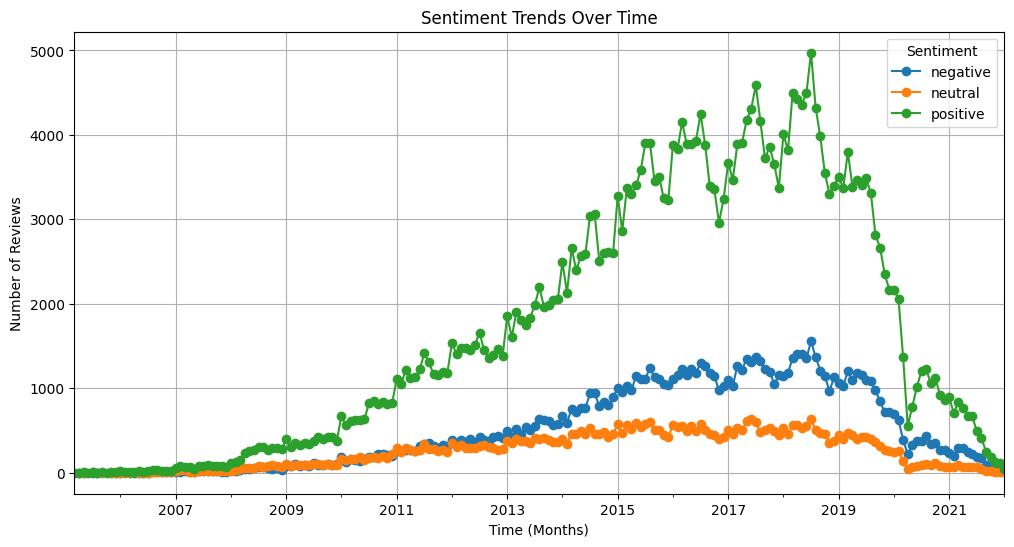

In [ ]:
import matplotlib.pyplot as plt

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Aggregate sentiment over time
sentiment_trends = df.groupby([df['date'].dt.to_period("M"), 'sentiment_label']).size().unstack()

# Plot sentiment trends over time
sentiment_trends.plot(figsize=(12,6), marker="o")
plt.title("Sentiment Trends Over Time")
plt.xlabel("Time (Months)")
plt.ylabel("Number of Reviews")
plt.legend(title="Sentiment")
plt.grid(True)
plt.show()


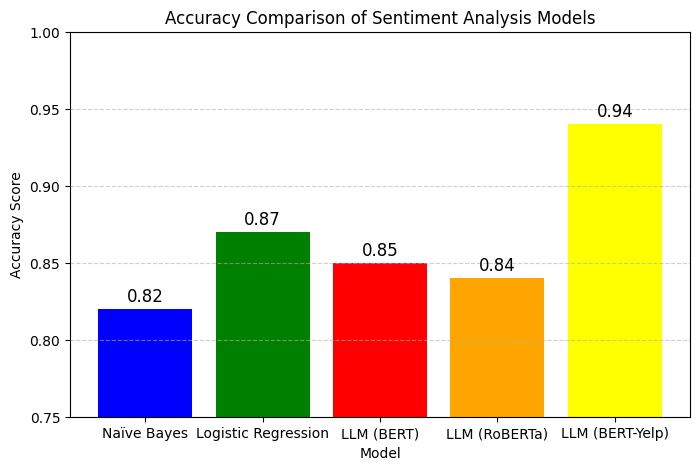

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Scores from Model Comparisons
models = ["Naïve Bayes", "Logistic Regression", "LLM (BERT)", "LLM (RoBERTa)",
    "LLM (BERT-Yelp)"]
accuracy_scores = [0.82, 0.87, 0.85, 0.84, 0.94]

# Create bar chart
plt.figure(figsize=(8, 5))
plt.bar(models, accuracy_scores, color=['blue', 'green', 'red', 'orange', 'yellow'])
plt.ylim(0.75, 1)  # Set y-axis limits

# Add labels & title
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Comparison of Sentiment Analysis Models")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show values on bars
for i, score in enumerate(accuracy_scores):
    plt.text(i, score + 0.005, f"{score:.2f}", ha='center', fontsize=12)

# Save the figure
plt.savefig("accuracy_comparison.png", bbox_inches="tight")
plt.show()


In [ ]:
# !pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

# Fine-Tune

In [3]:
import pandas as pd
import re
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import TrainingArguments, Trainer


In [4]:
# Load your preprocessed dataset
# Load the CSV back into a DataFrame
df = pd.read_csv("/content/drive/MyDrive/yelp_dataset/cleaned_reviews.csv")

# Clean & label
df = df[['cleaned_text', 'stars']].dropna()
df['sentiment_label'] = df['stars'].apply(lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral'))

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment_label'])  # e.g., 0=negative, 1=neutral, 2=positive

# Reduce for quick tuning (optional)
# df = df.sample(n=30000, random_state=42)


In [5]:
df.head()

,cleaned_text,stars,sentiment_label,label
0,decide eat aware going take 2 hour beginning e...,3.0,neutral,1
1,taken lot spin class year nothing compare clas...,5.0,positive,2
2,family diner buffet eclectic assortment large ...,3.0,neutral,1
3,wow yummy different delicious favorite lamb cu...,5.0,positive,2
4,cute interior owner gave u tour upcoming patio...,4.0,positive,2


In [6]:
# Downsample classes to handle imbalance
df_majority = df[df.label == 2]  # positive
df_minority = df[df.label != 2]

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced['label'].value_counts())


label
2    343321
0    228202
1    115119
Name: count, dtype: int64


In [7]:
train_df, val_df = train_test_split(df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label'])


In [9]:
model_name = "distilbert-base-uncased"  # or "bert-base-uncased", "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['cleaned_text'], padding=True, truncation=True, max_length=128)

# If using Hugging Face datasets
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df[['cleaned_text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['cleaned_text', 'label']])

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/549313 [00:00<?, ? examples/s]

Map:   0%|          | 0/137329 [00:00<?, ? examples/s]

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from transformers import TrainingArguments
print(TrainingArguments)


<class 'transformers.training_args.TrainingArguments'>


In [13]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",     # use "steps" for eval_steps to work
    eval_steps=500,                  # evaluate every 500 steps
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,     # also supported
    metric_for_best_model="accuracy",
    fp16=True                       # supported
)

def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


In [ ]:
trainer.train()


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.396900,0.548915,0.792367,0.777044,0.772718,0.792367
1000,0.514600,0.502171,0.792848,0.784983,0.786334,0.792848
1500,0.490700,0.471285,0.812370,0.801435,0.798041,0.812370


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.396900,0.548915,0.792367,0.777044,0.772718,0.792367
1000,0.514600,0.502171,0.792848,0.784983,0.786334,0.792848
1500,0.490700,0.471285,0.812370,0.801435,0.798041,0.812370
2000,0.463200,0.447274,0.817344,0.813305,0.810373,0.817344
2500,0.463600,0.436068,0.820854,0.815041,0.811366,0.820854
3000,0.457600,0.434955,0.825041,0.815836,0.812386,0.825041


In [ ]:
model.save_pretrained("./sentiment_model")
tokenizer.save_pretrained("./sentiment_model")


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("./sentiment_model")
